# Bayesian Linear Regression Starter

_Authors: Paul Bürkner, Lars Kühmichel, Stefan T. Radev_

## Introduction

Welcome to the very first tutorial on using BayesFlow for amortized posterior estimation! In this notebook, we will estimate a linear regression model and illustrate some features of the library along the way. This tutorial introduces the lower-level interface, which allows full control over all network and training parameters, as well as passing of all familiar `keras` callback functions.

In traditional Bayesian inference, we seek to approximate the posterior distribution of model parameters given observed data for each new data instance separately. This process can be computationally expensive, especially for complex models or large datasets, because it often involves iterative optimization or sampling methods. This step needs to be repeated for each new instance of data.

Amortized Bayesian inference offers a solution to this problem. “Amortization” here refers to spreading out the computational cost over multiple instances. Instead of computing a new posterior from scratch for each data instance, amortized inference learns a function. This function is parameterized by a neural network, that directly maps observations to an approximation of the posterior distribution. This function is trained over the dataset to approximate the posterior for *any* new data instance efficiently. In this example, we will use a simple Gaussian model to illustrate the basic concepts of amortized posterior estimation.

At a high level, our architecture consists of a summary network $\mathbf{h}$ and an inference network $\mathbf{f}$ which jointly learn to invert a generative model. The summary network transforms input data $\mathbf{x}$ of potentially variable size to a fixed-length representations. The inference network generates random draws from an approximate posterior $\mathbf{q}$ via a conditional generative networks (here, an invertible network).

In [1]:
import numpy as np

import keras
import bayesflow as bf

When using torch backend, we need to disable autograd by default to avoid excessive memory usage. Use

with torch.enable_grad():
    ...

in contexts where you need gradients (e.g. custom training loops).


BayesFlow offers flexible modules you can adapt to different Amortized Bayesian Inference (ABI) workflows. In brief:

* The module `simulators` contains high-level wrappers for gluing together priors, simulators, and meta-functions, and generating all quantities of interest for a modeling scenario.
* The module `adapters` contains utilities that preprocess the generated data from the simulator to a format more friendly for the neural approximators.
* The module `networks` contains the core neural architecture used for various tasks, e.g., a generative `FlowMatching` architecture for approximating distributions, or a `DeepSet` for learning permutation-invariant summary representations (embeddings).
* The module `appoximators` contains high-level wrappers which connect the various networks together and instruct them about their particular goals in the inference pipeline.

In this notebook we will take components from each of these modules and show how they work together.

In [2]:
# avoid scientific notation for outputs
np.set_printoptions(suppress=True)

## Generative Model

From the perspective of BayesFlow, a generative model is more than just a prior (encoding beliefs about the parameters before observing data) and a data simulator (a likelihood function, often implicit, that generates data given parameters). 

In addition, a model consists of various implicit context assumptions, which we can make explicit at any time. Furthermore, we can also amortize over these context variables, thus making our real-world inference more flexible (i.e., applicable to more contexts). We are leveraging the concept of amortized inference and extending it to context variables as well.

We will start with our data simulator: 

In [3]:
def likelihood(beta, sigma, N):
    # x: predictor variable
    x = np.random.normal(0, 1, size=N)
    # y: response variable
    y = np.random.normal(beta[0] + beta[1] * x, sigma, size=N)
    return dict(y=y, x=x)

As inputs, it takes the regression coefficient vector `beta` (intercept and slope), the residual SD `sigma`, and the number of observations `N` to simulate both our predictor variable `x` and subsequently our response variable `y`. 

In [4]:
data_draws = likelihood(beta = [2, 1], sigma = 1, N = 3)
print(data_draws["y"].shape)
print(data_draws["y"])

(3,)
[2.08489853 1.02115326 1.46841197]


Next, we define our prior simulator to sample draws of the model parameters `beta` and `sigma`:

In [5]:
def prior():
    # beta: regression coefficients (intercept, slope)
    beta = np.random.normal([2, 0], [3, 1])
    # sigma: residual standard deviation
    sigma = np.random.gamma(1, 1)
    return dict(beta=beta, sigma=sigma)

In [6]:
prior_draws = prior()
print(prior_draws["beta"].shape)
print(prior_draws["beta"])

(2,)
[-0.47796844  0.35522176]


If we fix the number of observations `N`, the combination of likelihood and prior already fully defines our model simulator. However, we want to train BayesFlow to perform posterior approximations of linear regression models for *varying number of observations*. As such, we also need a simulator for `N`:

In [7]:
def meta():
    # N: number of observation in a dataset
    N = np.random.randint(5, 15)
    return dict(N=N)

In [8]:
meta_draws = meta()
print(meta_draws["N"])

10


We can combine these three functions into a bayesflow simulator via:

In [9]:
simulator = bf.simulators.make_simulator([prior, likelihood], meta_fn=meta)

We passed the `meta` simulator separately to the `meta_fn` argument to make sure
that the number of observations `N` constant within each *batch* of simulated datasets. This is required since, within each batch, the generated datasets need to have the same shape for them to be easily transformable to tensors for deep learning.

Let's see how sampling from the simulator works by sampling a batch of 500 datasets:

In [10]:
# Generate a batch of three training samples
sim_draws = simulator.sample(500)
print(sim_draws["N"])
print(sim_draws["beta"].shape)
print(sim_draws["sigma"].shape)
print(sim_draws["x"].shape)
print(sim_draws["y"].shape)

7
(500, 2)
(500, 1)
(500, 7)
(500, 7)


Let's define the parameter key and corresponding names of individual parameters for easy filtering and plotting down the line.

In [11]:
par_keys = ["beta", "sigma"]
par_names = [r"$\beta_0$", r"$\beta_1$", r"$\sigma$"]

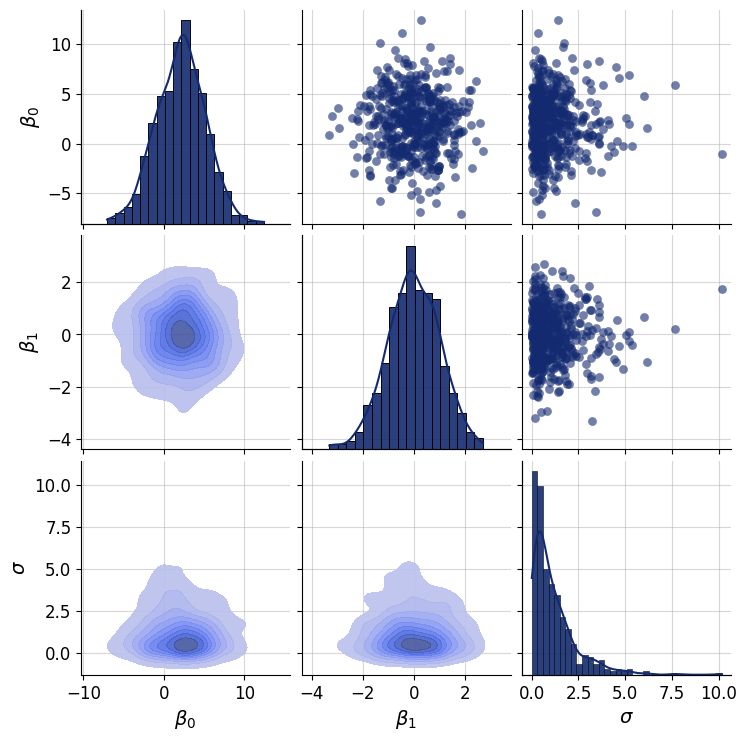

In [12]:
f = bf.diagnostics.plots.pairs_samples(
    samples=sim_draws,
    variable_keys=par_keys,
    variable_names=par_names
)

## Adapter

To ensure that the training data generated by the simulator can be used for deep learning, we have do a bunch of transformations via `adapter` objects. They provides multiple flexible functionalities, from standardization to renaming, and so on. 

Below, we build our own `adapter` from scratch but later on, `BayesFlow` will also provide default adapters that will already automate most of the commonly required steps.

In [13]:
adapter = (
    bf.Adapter()
    .broadcast("N", to="x")
    .as_set(["x", "y"])
    .constrain("sigma", lower=0)
    .standardize(exclude=["N"])
    .sqrt("N")
    .convert_dtype("float64", "float32")
    .concatenate(["beta", "sigma"], into="inference_variables")
    .concatenate(["x", "y"], into="summary_variables")
    .rename("N", "inference_conditions")
)

Let us discuss a few adapter steps in detail:

The `.broadcast("N", to="x")` transform will copy the value of `N` batch-size times to ensure that it will also have a `batch_size` dimension even though it was actually just a single value, constant over all datasets within a batch. The batch dimension will be inferred from `x` (this needs to be present during inference).

The `.as_set(["x", "y"])` transform indicates that both `x` and `y` are treated as sets. That is, their values will be treated as *exchangable* such that they will imply the same inference regardless of the values' order. This makes sense, since in linear regression, we can index the observations in arbitrary order and always get the same regression line.

The `.constrain("sigma", lower=0)` transform ensures that the residual standard deviation parameter `sigma` will always be positive. Without this constrain, the neural networks may attempt to predict negative `sigma` which of course would not make much sense.

Standardidazation via `.standardize()` is important for neural networks to learn
reliably without, for example, exploding or vanishing gradients during training. However, we need to exclude the variable `N` from standardization, via `standardize(exclude=["N"])`. This is because `N` is a constant within each batch of training data and can hence not be standardized. In the future, bayesflow will automatically detect this case so that we don't have to manually exclude such constant variables from standardization.

Let's check the shape of our processed data to be passed to the neural networks:

In [14]:
processed_draws = adapter(sim_draws)
print(processed_draws["summary_variables"].shape)
print(processed_draws["inference_conditions"].shape)
print(processed_draws["inference_variables"].shape)

(500, 7, 2)
(500, 1)
(500, 3)


Those shapes are as we expect them to be. The first dimenstion is always the batch size which was 500 for our example data. All variables adhere to this rule since the first dimension is indeed 500.

For `summary_variables`, the second dimension is equal to the sampled valued of `N`. It's third dimension is `2`, since we have combined `x` and `y` into summary variables, each of which are vectors of length `N` within each simulated dataset.

For `inference_conditions`, the second dimension is just `1` because we have passed only the scalar variable `N` there.

For `inference_variables`, the second dimension is `3` because it consists of
`beta` (a vector of length `2`) and `sigma` (a scalar).

## Neural Approximator

Below, we will define the neural networks that we will use to estimate the posterior distribution of our linear regression parameters.

### Summary Network

Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. Exchangeability in data means that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. In other words, the data is permutation invariant. For that, we will use a `SetTransformer` which does exactly that (a `DeepSet` is a cheaper version for simpler problems). 

This network will take (at least) 3D tensors of shape `(batch_size, num_obs, D)` and reduce them to 2D tensors of shape `(batch_size, summary_dim)`, where `summary_dim` is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model. Below, we create a permutation-invariant network with `summary_dim = 10`:

In [15]:
summary_network = bf.networks.SetTransformer(summary_dim=10)

### Inference Network

To actually approximate the posterior distribution, we need to define a generative neural network. Here we choose a simple coupling flow network. For more complicated models and corresponding posteriors, we may need to choose a different, more flexible generative network, for example `bf.networks.FlowMatching()`.

In [16]:
inference_network = bf.networks.CouplingFlow()

### Workflow

Workflow objects make life easier by combining inference networks and summary networks into approximators (internally).

In [17]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_network,
    summary_network=summary_network,
)

Now, we are ready to train our approximator to learn posterior distributions for linear regression models. To achieve this, we will all `approximator.fit` passing the `simulator` and a bunch of hyperparameters that control how long we want to train.

**Note**: when using JAX and the shape of your data differs in every batch (e.g., when observations vary), you will observe some compilation overhead during the first few steps. The total training time for this example is around 2 minutes on a standard laptop.

In [ ]:
history = workflow.fit_online(epochs=50, batch_size=64, num_batches_per_epoch=200)

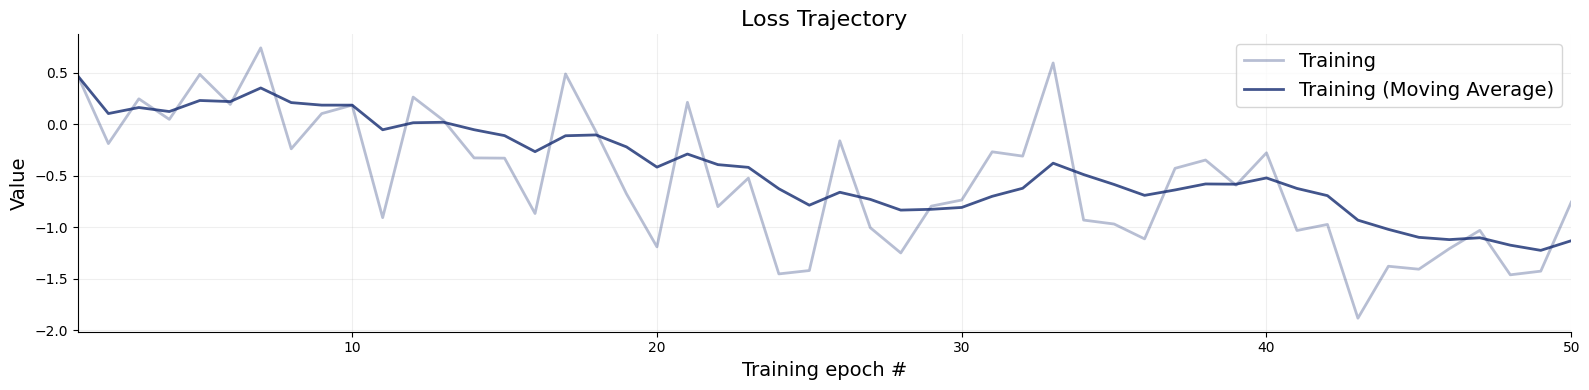

In [19]:
f = bf.diagnostics.plots.loss(history, )

## Diagnostics

Let's check out the resulting inference. Say we want to obtain 1000 posterior samples from our approximated posterior of a simulated dataset where we know the ground truth values.

You can also explore the automated diagnostics available through the methods:

- `compute_default_diagnostics()`
- `plot_default_diagnostics()`

In [22]:
# Set the number of posterior draws you want to get
num_samples = 1000

# Simulate validation data (unseen during training)
val_sims = simulator.sample(200)

# Obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = workflow.sample(conditions=val_sims, num_samples=num_samples)

# post_draws is a dictionary of draws with one element per named parameters
post_draws.keys() 

dict_keys(['beta', 'sigma'])

Initial sanity checks of the posterior samples look good. `post_draws["beta"]` has shape `(200, 2000, 2)` which makes sense since we asked for inference of a 200 data sets (first dimension is 200), for which we wanted to generated 1000 posterior samples (second dimension is 1000). The third dimension is 2, since the `beta` variable was defined as a vector of length 2 (intercept and slope).

In [23]:
post_draws["sigma"].min()

2.8543972559122407e-09

The minimun posterior sample of `sigma` is positive indicating that our positivity enforcing constraing in the data adapter has indeed worked.

Let's plot the joint posterior distribution of `beta` (both intercept and slope). Based on how we generated this particular dataset, we would expect the posteriors of `beta` to vary around its true values from `val_sims["beta"]`. Of course, if this was real data, we wouldn't know the ground truth values. Still, it is always a good idea to first perform inference on simulated data as a diagnostic for whether the approximator has learned to approximate the true posteriors well enough. We will examplariy check the posterior of the first dataset:

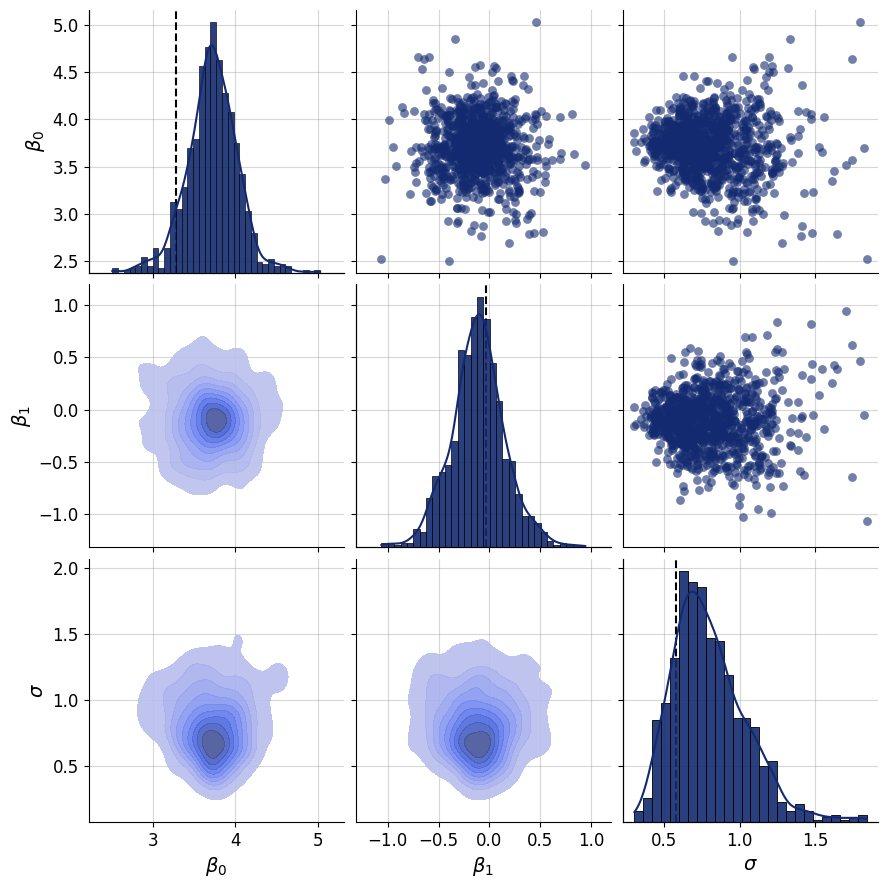

In [24]:
f = bf.diagnostics.plots.pairs_posterior(
    estimates=post_draws, 
    targets=val_sims,
    dataset_id=0,
    variable_names=par_names,
)

The true parameter values of the first dataset are indeed well covered by the posterior. Let's check this more systematically for all validation datasets:

**Note**: We are validating recovery for a given $N$ that happened to be drawn in the validation phase. Naturally, results will vary for different $N$, but you can simply leverage the power of amortization to check recovery over the entire range of plausble observation numbers. For an actual scientific application, you would want to train longer.

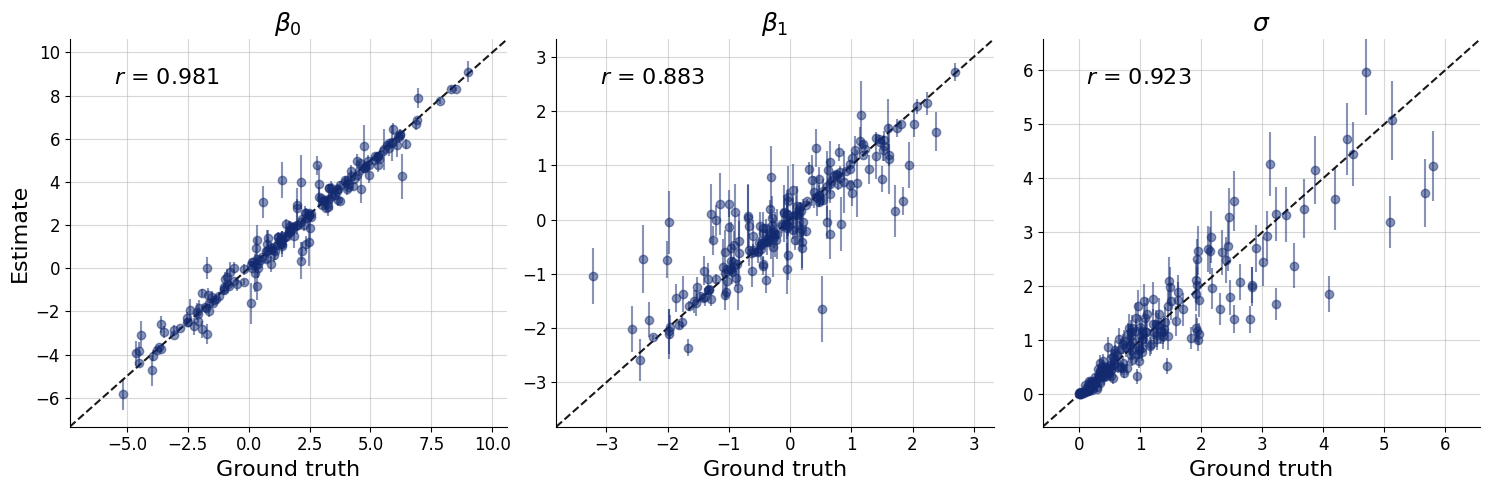

In [25]:
f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

Accuracy looks good for most datasets There is some more variation especially for $\beta_1$ and $\sigma$ but this is not necessarily a reason for concern. Keep in mind that perfect accuracy is not the goal of bayesflow inference. Rather, the goal is to estimate the correct posterior as close as possible. And this correct posterior might very well be far away from the true value for some datasets. In fact, we would fully expect the true value to sometimes be at the tail of the posterior. 

If this was not the case, than our posterior approximation may be too wide. Unfortunately, in many cases we don't have access to the correct posterior, so we need a method that provides us with an indication of the posterior approximations' accuracy without. This is where simulation-based calibration (SBC) comes into play. In short, if the true values are simulated from the prior used during inference (as is the case for our validatian data above), We would expect the rank of the true parameter value to be uniformly distributed from 1 to `num_samples`.

There are multiple graphical methods that use this property for diagnostics. For example, we can use histograms together with an uncertainty band within which we would expect the histogram bars to be if the rank statistics were indeed uniform.

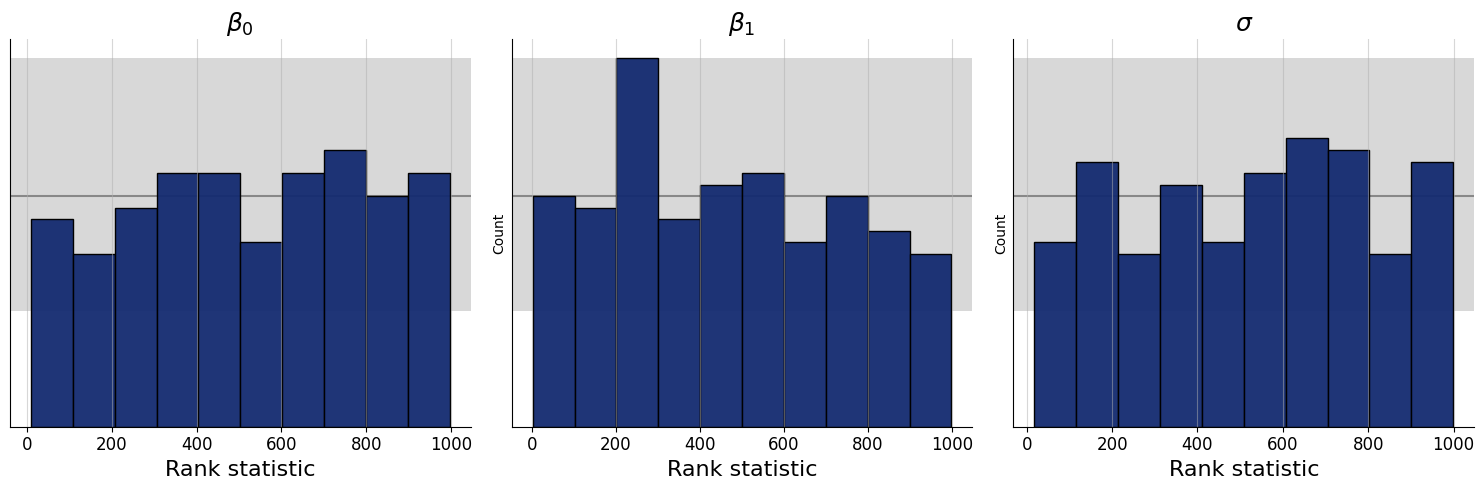

In [26]:
f = bf.diagnostics.plots.calibration_histogram(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)

The histograms look quite good overall, but could be a bit more uniform. That said, the SBC histograms have some drawbacks on how the confidence bands are computed, so we recommend using another kind of plot that is based on the empirical cumulative distribution function (ECDF). For the ECDF, we can compute better confidence bands than for histograms, so the SBC ECDF plot is usually preferable. [This SBC interpretation guide by Martin Modrák](https://hyunjimoon.github.io/SBC/articles/rank_visualizations.html) gives further background information and also practical examples of how to interpret the SBC plots.

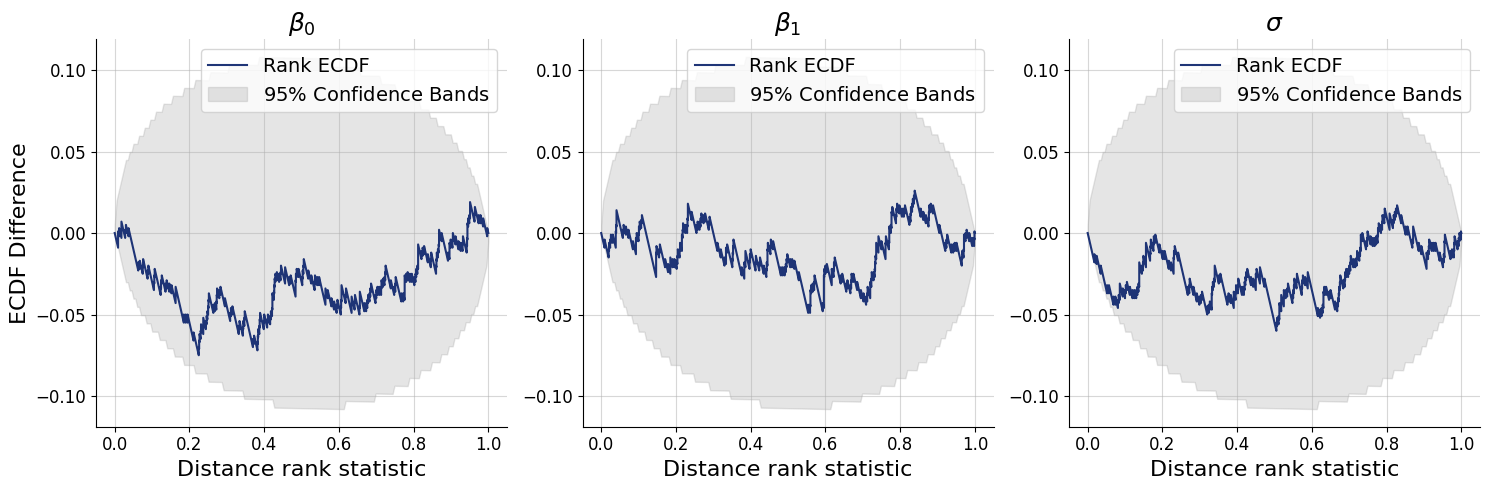

In [27]:
f = bf.diagnostics.plots.calibration_ecdf(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names,
    difference=True,
    rank_type="distance"
)

The plot confirms that the approximate posteriors are well calibrated, except for the small issues that we had already seen in the histograms. Likely, for fully well calibrated inference, we would have to train the approximator a little longer, but that's okay. After all, we can effort a little more training time since afterwards, inference on any number of new (real or simulated) datasets is very fast due to amortization.

After having convinced us that the posterior approximation are overall reasonable, we can check how much and what kind of information in the data we encode in the posterior. Specifically, we might want to look at two interesting scores: (a) The posterior contraction, which measures how much smaller the posterior variance is relative to the prior variance (higher values indicate more contraction relative to the prior). (b) The posterior z-score which indicates the standardized difference between the posterior mean and the true parameter value. Since the posterior z-score requires the true parameter values, it can only be computed in simulated data settings. Here, we show the results for the $\beta$ coefficients only to illustrate the use of the `variable_keys` argument.

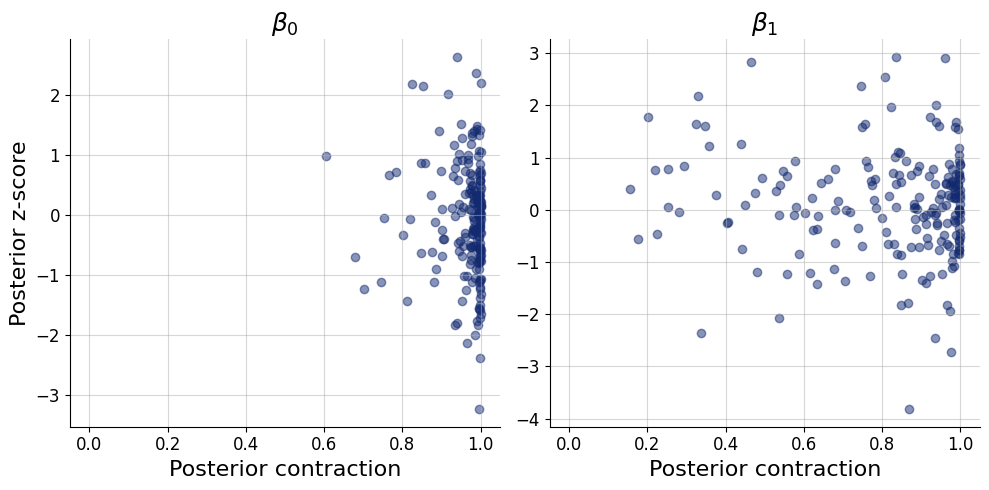

In [28]:
f = bf.diagnostics.plots.z_score_contraction(
    estimates=post_draws, 
    targets=val_sims,
    variable_keys=["beta"],
    variable_names=par_names[0:2]
)

We clearly see strong posterior contraction in almost all posteriors of $\beta_0$ and in most posteriors of $\beta_1$. In the latter case, there are some notable exceptions where little learning from prior to posterior has taken place. Most likely this is because the variance of the sample predictor value $x$ was small, leading to reduced information about the slope $\beta_1$. 

In terms of posterior z-score, most estimates are between -2 and 2, which makes sense if our posterior is approximately normal and well calibrated. However, again, there are some notable exceptions with quite large posterior z-scores over greater than 3 in absolute values. These may be cases, where the learned posterior approximation was not yet fully accurate. So likely, these extreme cases would vanish if we trained our approximator a little longer. 

### Saving and Loading the Trained Networks

For saving and later on reloading bayesflow approximators, we provide some convenient functionalities. For saving, we use:

In [30]:
# Recommended - full serialization (checkpoints folder must exist)
workflow.approximator.save(filepath="checkpoints/regression.keras")

# Not recommended due to adapter mismatches - weights only
# approximator.save_weights(filepath="checkpoints/regression.h5")

2025-04-21 11:54:04.969579: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 11:54:04.977366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745250844.984817 4140753 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745250844.987174 4140753 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745250844.993850 4140753 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

For loading, we then use:

In [31]:
# Load approximator
approximator = keras.saving.load_model("checkpoints/regression.keras")

/home/radevs/anaconda3/envs/bf/lib/python3.11/site-packages/keras/src/saving/serialization_lib.py:734: UserWarning: `compile()` was not called as part of model loading because the model's `compile()` method is custom. All subclassed Models that have `compile()` overridden should also override `get_compile_config()` and `compile_from_config(config)`. Alternatively, you can call `compile()` manually after loading.
  instance.compile_from_config(compile_config)


All the usual methods continue to work on the loaded approximator. For example:

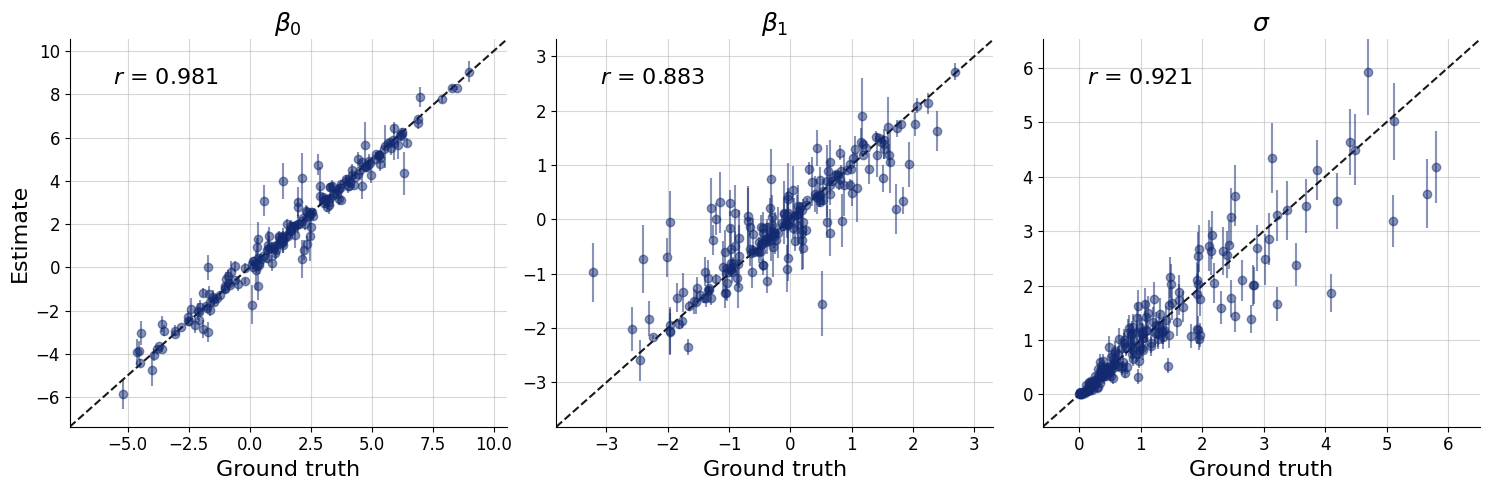

In [32]:
# Again, obtain num_samples samples of the parameter posterior for every validation dataset
post_draws = approximator.sample(conditions=val_sims, num_samples=num_samples)

f = bf.diagnostics.plots.recovery(
    estimates=post_draws, 
    targets=val_sims,
    variable_names=par_names
)